In [1]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split
from hyperopt import hp
import imp
import copy

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

In [2]:
from modules.data import data_maker
from modules.RNN import double_RNN
from modules.fit import Model, fit, predict, mae, rmse, load_exp
from modules.data import pka_scaler
from modules.myhyperopt import hyperopt_func
from modules.MPNN import double_MPNN

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [52]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
acids = data['Acid type'].tolist()
solvent_names = data['Solvent name'].tolist()
data_size = len(solute)

In [53]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
datasets = data_maker(solute, solvent, pka)

In [5]:
DMPNN = Model(name='DMPNN',
              model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='ReLU', 
                                atom_messages=False, dropout=0, interaction=None, readout='sum'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
DMPNN_att = Model(name='DMPNN with attention',
              model=double_MPNN(MP_depth=4, MP_hidden=128, NN_depth=4, NN_hidden=64, activation='ELU', 
                                atom_messages=False, dropout=0, interaction='tanh', readout='mean'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
MPNN = Model(name='MPNN',
             model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='LeakyReLU', 
                                  atom_messages=True, dropout=0, interaction=None, readout='sum'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
MPNN_att = Model(name='MPNN with attention',
             model=double_MPNN(MP_depth=2, MP_hidden=64, NN_depth=4, NN_hidden=512, activation='ReLU', 
                                  atom_messages=True, dropout=0, interaction='tanh', readout='max'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
RNN = Model(name='RNN',
            model=double_RNN(NN_depth=3, NN_hidden=512, RNN_hidden=512, activation='ReLU', dropout=0.3,
                             features=300, interaction=None, readout='max'),
            lr=0.001,
            batch_size=32,
            model_type='torch',
            data_type='sentences')
RNN_att = Model(name='RNN with attention',
                model=double_RNN(NN_depth=1, NN_hidden=1024, RNN_hidden=512, activation='PReLU', dropout=0.1,
                                 features=300, interaction='exp', readout='max'),
                lr=0.001,
                batch_size=32,
                model_type='torch',
                data_type='sentences')
RF_desc = Model(name='Random forest with descriptors',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='descriptors')
RF_ECFP = Model(name='Random forest with ECFP',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='ECFP')
MLP_desc = Model(name='MLP with descriptors',
                 model=MLPRegressor(activation='logistic', batch_size=32, early_stopping=True, hidden_layer_sizes=(512, 256, 128), solver='adam'),
                 model_type='sklearn',
                 data_type='descriptors')
MLP_ECFP = Model(name='MLP with ECFP',
                 model=MLPRegressor(activation='relu', batch_size=16, early_stopping=True, hidden_layer_sizes=(256, 128, 64), solver='adam'),
                 model_type='sklearn',
                 data_type='ECFP')
XGB_desc = Model(name='XGBoost with descriptors',
                 model=XGBRegressor(colsample_bytree=0.7, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.9),
                 model_type='sklearn',
                 data_type='descriptors')
XGB_ECFP = Model(name='XGBoost with ECFP',
                 model=XGBRegressor(colsample_bytree=0.6, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.8),
                 model_type='sklearn',
                 data_type='ECFP')
#list of all models for testing
models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]
#models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att]
#models = [RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]

In [48]:
#loading models
for m in models:
    print(m.name)
    data = datasets[m.data_type]
    load_exp(m, "Holdout test", data, CV_ids)

DMPNN
DMPNN with attention
MPNN
MPNN with attention
RNN
RNN with attention
Random forest with descriptors
Random forest with ECFP
MLP with descriptors
MLP with ECFP
XGBoost with descriptors
XGBoost with ECFP


In [54]:
for m in models:
    print(m.name)
    data = datasets[m.data_type]
    targets, outputs = predict(m, "Holdout test", data, holdout_ids)
    print(mae(targets, outputs))

DMPNN
0.866337
DMPNN with attention
1.2241936
MPNN
1.1339185
MPNN with attention
1.0794331
RNN
1.3995168
RNN with attention
1.2510136
Random forest with descriptors
1.2795535112859528
Random forest with ECFP
1.3572536135785302
MLP with descriptors
1.0737210589068176
MLP with ECFP
1.3265462717334964
XGBoost with descriptors
1.0486802892701361
XGBoost with ECFP
1.2036639205489594


DMPNN
Acetonitrile 1.4104409 2.0554388
DCE 2.2217472 3.49095
DMF 1.1199648 1.2334636
DMSO 0.67674094 0.8558355
THF 1.3059089 1.6313338
Water 0.7660761 1.1474432


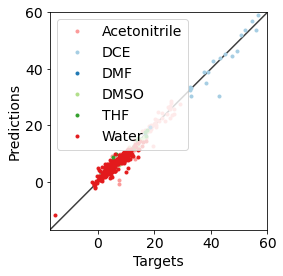

DMPNN with attention
Acetonitrile 1.7971718 2.329275
DCE 2.643425 3.781999
DMF 0.8430013 1.1090794
DMSO 1.158172 1.4947793
THF 1.4982854 2.046475
Water 1.1614199 1.5490315


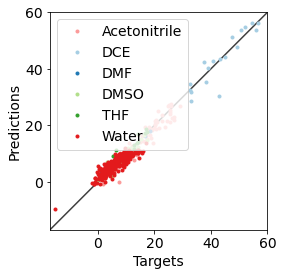

MPNN
Acetonitrile 1.6692448 2.114938
DCE 2.2330122 3.0480626
DMF 0.76547134 0.9153564
DMSO 1.2644521 1.4679351
THF 2.1219697 2.3717155
Water 0.9645273 1.3210927


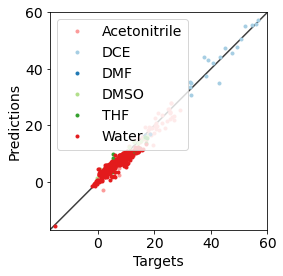

MPNN with attention
Acetonitrile 1.5864875 2.0276816
DCE 2.6511397 3.551196
DMF 1.0876906 1.2598224
DMSO 0.9697829 1.2418636
THF 1.2106881 1.7839676
Water 1.0363176 1.3812349


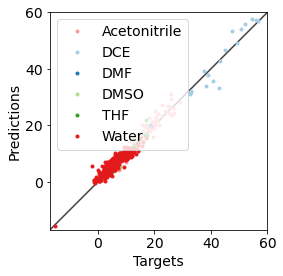

RNN
Acetonitrile 2.3998127 3.2827864
DCE 5.706603 8.157824
DMF 1.8624145 2.1896584
DMSO 1.5260503 1.8333919
THF 1.5302297 2.051142
Water 1.2318108 1.6985317


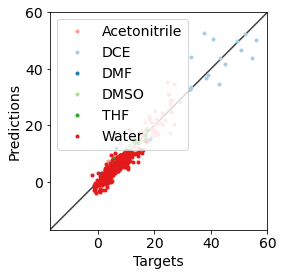

RNN with attention
Acetonitrile 2.0025063 2.5859938
DCE 3.140193 3.7468545
DMF 1.3305088 1.8203349
DMSO 1.0692265 1.4675603
THF 2.0986898 2.3570962
Water 1.0429411 1.4576694


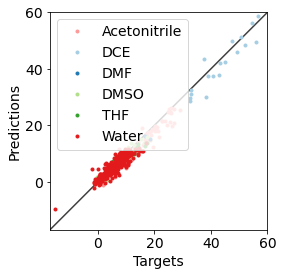

Random forest with descriptors
Acetonitrile 2.601263445633721 3.793132365660857
DCE 3.0374433199029705 4.047075429157433
DMF 2.9805874216990578 3.364445615559759
DMSO 1.7173889508124995 2.5695759417855117
THF 2.594802194036233 3.4088142758735107
Water 0.9369644215081278 1.4508744003854424


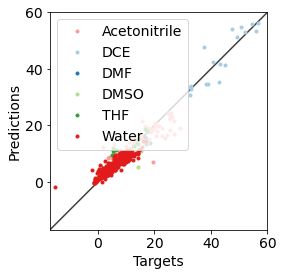

Random forest with ECFP
Acetonitrile 2.2718322448760926 3.2758689491950874
DCE 2.76846760024783 4.651482750232509
DMF 4.35895296401581 5.160232228983357
DMSO 1.5627772706489007 2.278507055575506
THF 2.170075722766597 3.2237899348755885
Water 1.1062908314974274 1.797716332535086


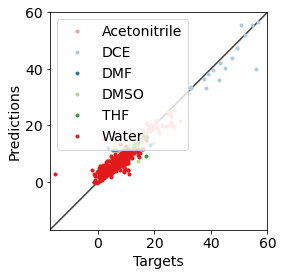

MLP with descriptors
Acetonitrile 1.7443849688753197 2.8993486813985765
DCE 2.400844755192779 3.0701821192270256
DMF 1.204970827239447 1.5006785687651247
DMSO 1.2117076259951447 1.9101889803855858
THF 1.8756897220375537 2.613817878728009
Water 0.891023476031909 1.270914678757975


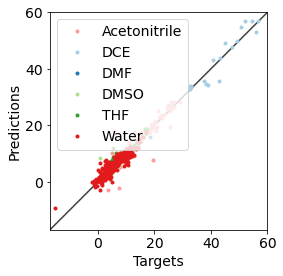

MLP with ECFP
Acetonitrile 1.9706501410090298 2.9625540141606392
DCE 2.9522193053076378 3.78773172814234
DMF 0.41719369133825424 0.5030170120202269
DMSO 1.096917085273476 1.4741315487914968
THF 1.7311747157570443 2.5396361200039657
Water 1.174874000405834 1.7017877116646107


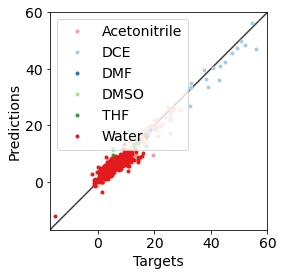

XGBoost with descriptors
Acetonitrile 1.8383129711787707 2.701490930365988
DCE 2.3241400755862083 2.9337940638689526
DMF 1.3330907154083245 1.6002249405936237
DMSO 1.4863008324916542 1.9923325209929281
THF 1.3752362720782945 1.7615106665176967
Water 0.8445336735733139 1.1968537423420629


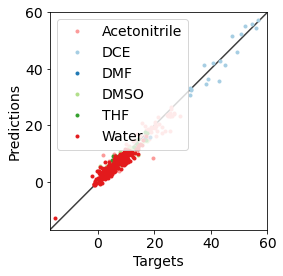

XGBoost with ECFP
Acetonitrile 1.5849709163187005 2.2840316432768684
DCE 2.5378265947851557 3.5418137634653992
DMF 1.53769059062004 1.8943448984162157
DMSO 0.924837066577031 1.4108891429604868
THF 1.3182381365849427 1.6714955911948766
Water 1.104267966018577 1.6428601095369801


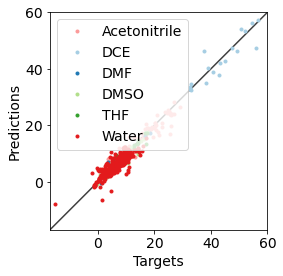

In [55]:
##qqplots solvent
solv_set = ['CC#N','C(CCl)Cl','CN(C)C=O','CS(=O)C','C1CCOC1','O']
solvent_name_key = {"CS(=O)C":"DMSO","CC#N":"Acetonitrile","C(CCl)Cl":"DCE","CN(C)C=O":"DMF","C1CCOC1":"THF","O":"Water"}
solv_names = ["Water","DCE","DMF","DMSO","THF","Acetonitrile"]

colour_key = {'DCE':'#a6cee3','DMF':'#1f78b4','DMSO':'#b2df8a','THF':'#33a02c','Acetonitrile':'#fb9a99','Water':'#e31a1c'}
solv_ids = ddict()
solv_MAEs = ddict(list)
for solv in solv_set:
    solv_ids[solv] = [i for i,x in enumerate(solvent) if x == solv and i in holdout_ids]
    solv_MAEs['solvent'].append(solvent_name_key[solv])
for m in models:
    print(m.name)
    data = datasets[m.data_type]
#    targets, outputs = predict(m, "Holdout test", data, solv_ids['O'])
#    solv_name = solvent_name_key['O']
#    plt.plot(targets, outputs, 'o', markersize=3,label=solv_name, c=colour_key[solv_name])
#    solv_MAEs[m.name].append(mae(targets,outputs))
#    print('water', mae(targets,outputs),rmse(targets,outputs))
    for solv in solv_set:
#        if solv not in 'O':
            targets, outputs = predict(m, "Holdout test", data, solv_ids[solv])
            solv_name = solvent_name_key[solv]
            plt.plot(targets, outputs, 'o', markersize=3,label=solv_name, c=colour_key[solv_name])
            print(solv_name, mae(targets,outputs),rmse(targets,outputs))
            solv_MAEs[m.name].append(mae(targets,outputs))

    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    lims = [-17,60]
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axes=plt.gca()
    axes.set_aspect('equal')
    axes.set_xlim(lims)
    axes.set_ylim(lims)
    axes.legend()
    plt.show()

        solvent  DMPNN  DMPNN with attention  MPNN  MPNN with attention   RNN  \
0  Acetonitrile  1.410                 1.797 1.669                1.586 2.400   
1           DCE  2.222                 2.643 2.233                2.651 5.707   
2           DMF  1.120                 0.843 0.765                1.088 1.862   
3          DMSO  0.677                 1.158 1.264                0.970 1.526   
4           THF  1.306                 1.498 2.122                1.211 1.530   
5         Water  0.766                 1.161 0.965                1.036 1.232   

   RNN with attention  Random forest with descriptors  \
0               2.003                           2.601   
1               3.140                           3.037   
2               1.331                           2.981   
3               1.069                           1.717   
4               2.099                           2.595   
5               1.043                           0.937   

   Random forest with ECFP  MLP 

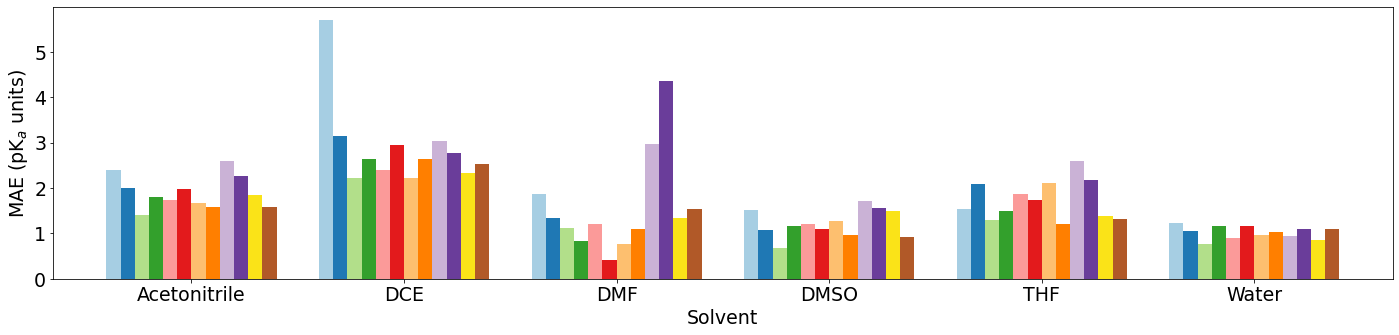

[0, 70, 16, 104, 52, 0]
[0, 18, 4, 26, 13, 0]
[2015, 320]
[504, 80]
[2519, 400]


In [212]:
solv_MAEs = pd.DataFrame(solv_MAEs)
print(solv_MAEs)

df_pivot = solv_MAEs
df_pivot = df_pivot.rename(columns = 
                           {'Random forest with descriptors': 'RF w/ desc.','Random forest with ECFP': 'RF w/ ECFP',
                           'MLP with descriptors': 'FNN w/ desc.', 'MLP with ECFP': 'FNN w/ ECFP', 'DMPNN':'D-MPNN',
                           'RNN':'biLSTM', 'RNN with attention':'biLSTM w/ int.', 
                            'DMPNN with attention':'D-MPNN w/ int.', 'MPNN with attention':'MPNN w/ int.',
                           'XGBoost with descriptors':'XGBoost w/ desc.', 'XGBoost with ECFP':'XGBoost w/ ECFP'})
cols = ['solvent', 'biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]
df_pivot = df_pivot[sorted(cols, key=str.lower)]

df_pivot[['solvent','biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.']].to_csv('holdout_solv.csv')

colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
           '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#FAE318','#b15928']

ax = df_pivot.plot.bar(x='solvent',color=colours, width=0.8, legend=False)
fig = ax.get_figure()
fig.set_size_inches(24,5)
ax.set_xlabel("Solvent")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 

# Put a legend below current axis
plt.savefig('holdout_solvents.pdf', bbox_inches='tight')
plt.show()
train_solv = [solvent_names[i] for i in CV_ids]
test_solv = [solvent_names[i] for i in holdout_ids]
train_counts = [train_solv.count(name) for name in solv_MAEs['solvent']]
test_counts = [test_solv.count(name) for name in solv_MAEs['solvent']]
print(train_counts)
print(test_counts)
print([train_solv.count(name) for name in ['water','acetonitrile']])
print([test_solv.count(name) for name in ['water','acetonitrile']])
print([solvent_names.count(name) for name in ['water','acetonitrile']])

DMPNN


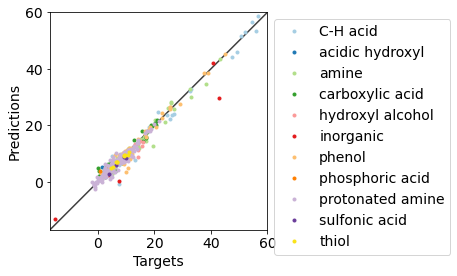

DMPNN with attention


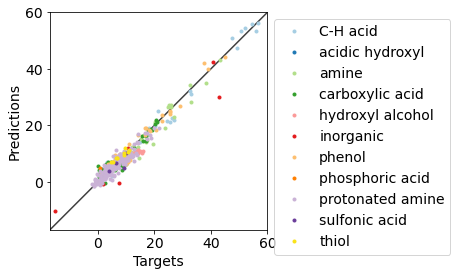

MPNN


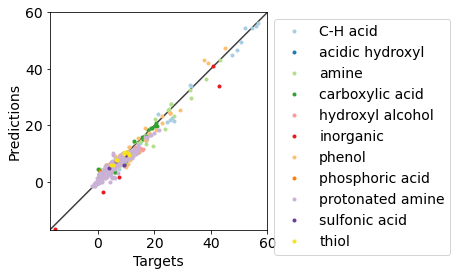

MPNN with attention


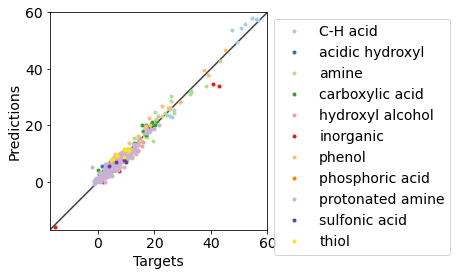

RNN


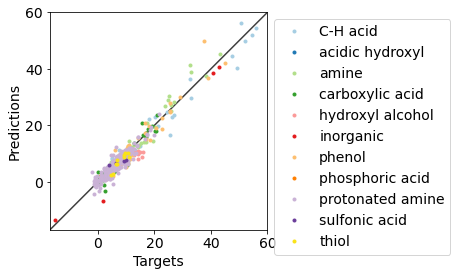

RNN with attention


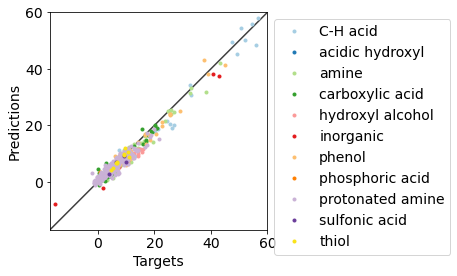

Random forest with descriptors


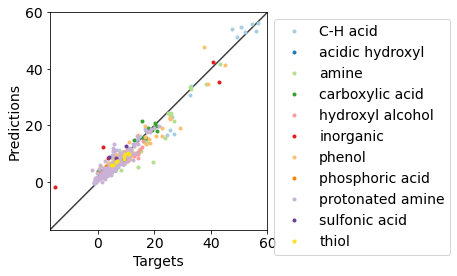

Random forest with ECFP


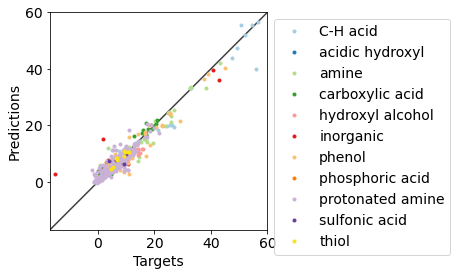

MLP with descriptors


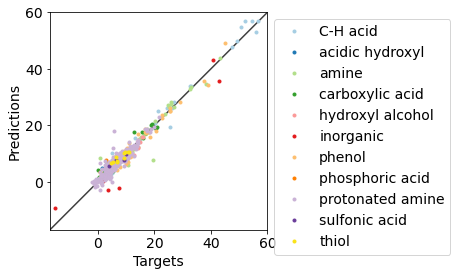

MLP with ECFP


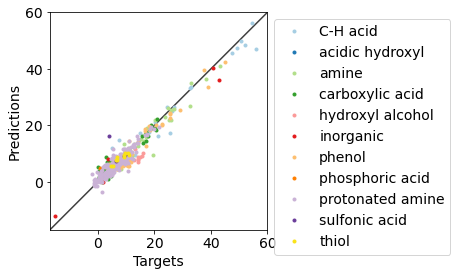

XGBoost with descriptors


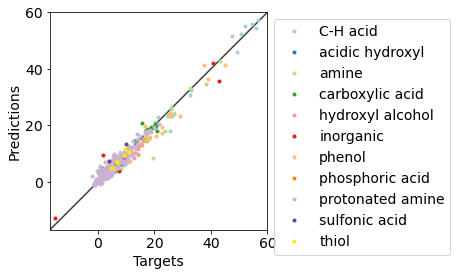

XGBoost with ECFP


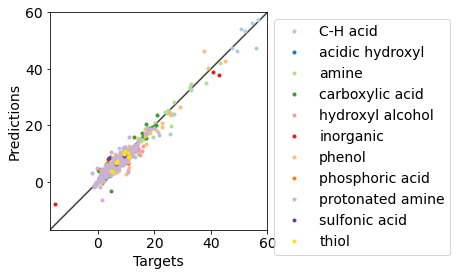

           acid type  DMPNN  DMPNN with attention  MPNN  MPNN with attention  \
0           C-H acid  1.941                 2.127 1.858                1.645   
1    acidic hydroxyl  1.497                 1.590 0.879                2.274   
2              amine  1.093                 1.411 1.295                1.154   
3    carboxylic acid  1.049                 1.411 0.910                0.937   
4   hydroxyl alcohol  1.200                 2.793 2.198                1.501   
5          inorganic  3.677                 4.466 3.424                3.350   
6             phenol  0.931                 1.142 1.129                1.323   
7    phosphoric acid  2.625                 2.835 3.066                1.426   
8   protonated amine  0.639                 0.976 1.011                0.914   
9      sulfonic acid  1.005                 1.262 1.348                1.740   
10             thiol  0.328                 1.357 0.925                1.810   

     RNN  RNN with attention  Random fo

In [57]:
##qqplots acids
acid_set = ['C-H acid', 'acidic hydroxyl', 'amine', 'carboxylic acid', 'hydroxyl alcohol', 'inorganic', 'phenol', 'phosphoric acid', 'protonated amine', 'sulfonic acid', 'thiol']
acid_ids = ddict()
for acid in acid_set:
    acid_ids[acid] = [i for i,x in enumerate(acids) if x == acid and i in holdout_ids]
    
acid_MAEs = ddict(list)
acid_MAEs['acid type'] = acid_set
for m in models:
    print(m.name)
    data = datasets[m.data_type]
    i=0
    for acid in acid_set:
        targets, outputs = predict(m, "Holdout test", data, acid_ids[acid])
        plt.plot(targets, outputs, 'o', markersize=3,label=acid, c=colours[i])
        acid_MAEs[m.name].append(mae(targets,outputs))
        i+=1

    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    lims = [-17,60]
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axes=plt.gca()
    axes.set_aspect('equal')
    axes.set_xlim(lims)
    axes.set_ylim(lims)
    axes.legend(bbox_to_anchor=(1,1))
    plt.show()
    
acid_MAEs = pd.DataFrame(acid_MAEs)
print(acid_MAEs)

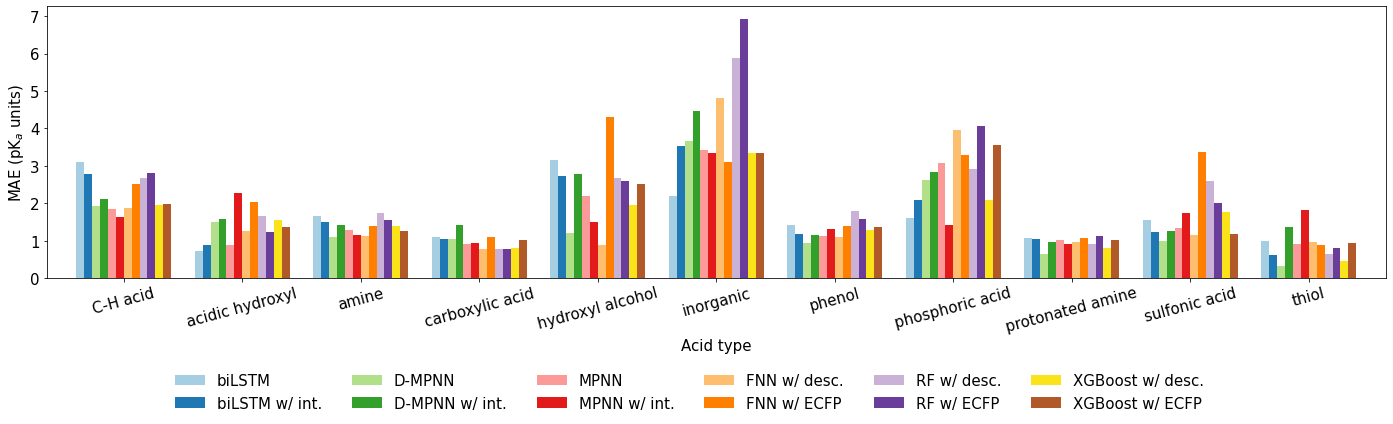

[117, 18, 237, 367, 52, 24, 303, 8, 1398, 17, 36]
[28, 3, 57, 91, 14, 7, 93, 2, 336, 4, 10]


In [202]:
df_pivot = acid_MAEs.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = df_pivot.rename(columns = 
                           {'Random forest with descriptors': 'RF w/ desc.','Random forest with ECFP': 'RF w/ ECFP',
                           'MLP with descriptors': 'FNN w/ desc.', 'MLP with ECFP': 'FNN w/ ECFP', 'DMPNN':'D-MPNN',
                           'RNN':'biLSTM', 'RNN with attention':'biLSTM w/ int.', 
                            'DMPNN with attention':'D-MPNN w/ int.', 'MPNN with attention':'MPNN w/ int.',
                           'XGBoost with descriptors':'XGBoost w/ desc.', 'XGBoost with ECFP':'XGBoost w/ ECFP'})
cols = ['acid type', 'biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

df_pivot[['acid type','biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.']].to_csv('holdout_acid.csv')

colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
           '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#FAE318','#b15928']

ax = df_pivot.plot.bar(x='acid type',color=colours, width=0.8)
fig = ax.get_figure()
fig.set_size_inches(24,5)
ax.set_xlabel("Acid type")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=15) 

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.48, -0.3), fancybox=False, shadow=False, ncol=6, frameon=False)
plt.savefig('holdout_acid.pdf', bbox_inches='tight')
plt.show()
train_acids = [acids[i] for i in CV_ids]
test_acids = [acids[i] for i in holdout_ids]
train_counts = [train_acids.count(name) for name in acid_set]
test_counts = [test_acids.count(name) for name in acid_set]
print(train_counts)
print(test_counts)

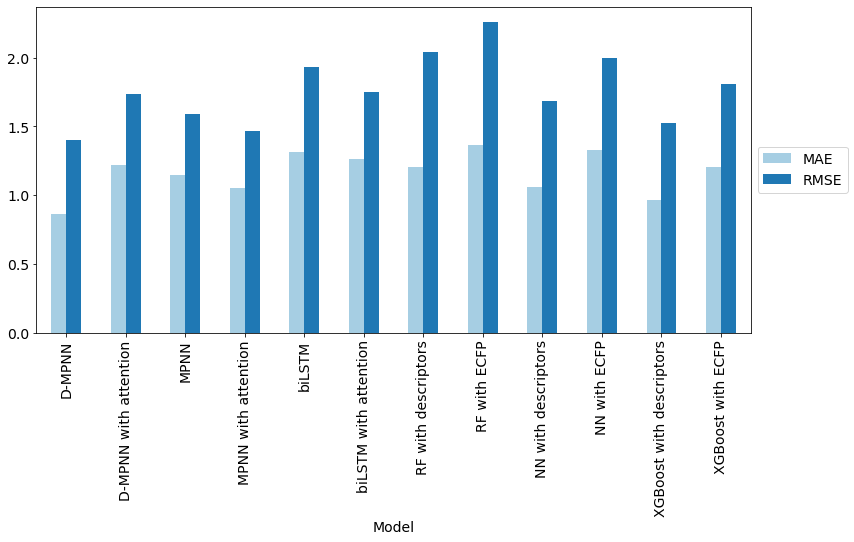

    Unnamed: 0                     Model   MAE  RMSE
0            0                    D-MPNN 0.863 1.404
1            1     D-MPNN with attention 1.217 1.735
2            2                      MPNN 1.144 1.593
3            3       MPNN with attention 1.053 1.468
4            4                    biLSTM 1.312 1.935
5            5     biLSTM with attention 1.262 1.752
6            6       RF with descriptors 1.207 2.043
7            7              RF with ECFP 1.366 2.258
8            8       NN with descriptors 1.063 1.685
9            9              NN with ECFP 1.329 2.000
10          10  XGBoost with descriptors 0.964 1.525
11          11         XGBoost with ECFP 1.203 1.809


In [59]:
#holdout test

df = pd.read_csv('finalised_results/holdout_test_new.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
ax = df.plot.bar(x='Model', y=['MAE','RMSE'], color=colours)

fig = ax.get_figure()
fig.set_size_inches(16, 6)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print(df)

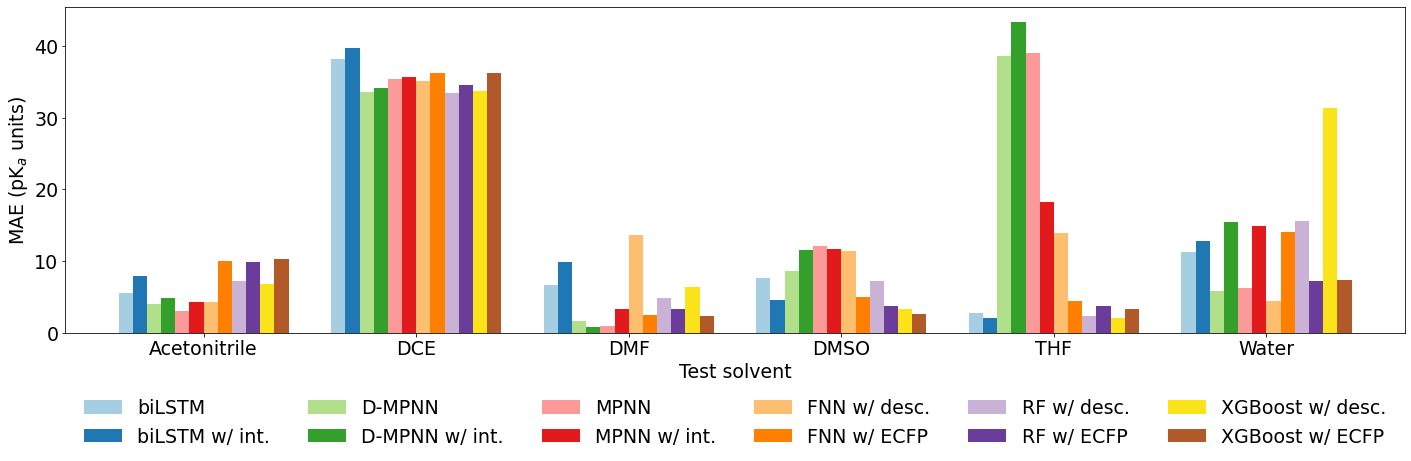

In [185]:
#LOSO
df = pd.read_csv('finalised_results/LOSO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','with attention':'w/ int.', 'with descriptors':'w/ desc.', 'with ECFP':'w/ ECFP'}, regex=True)

solvent_name_key = {"CS(=O)C":"DMSO","CC#N":"Acetonitrile","C(CCl)Cl":"DCE","CN(C)C=O":"DMF","C1CCOC1":"THF","O":"Water"}
df = df.replace(solvent_name_key)

df_pivot = pd.pivot_table(df, values="MAE", index=r"LOSO solvent", columns="Model")
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
           '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#FAE318','#b15928']

ax = df_pivot.plot.bar(color=colours, width=0.8)
fig = ax.get_figure()
fig.set_size_inches(24,6)
ax.set_xlabel("Test solvent")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 

# Put a legend below current axis
plt.rc("font", size=19)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=6, frameon=False)
#ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1), fancybox=False, shadow=False, ncol=1, frameon=False)
plt.savefig('LOSO.pdf', bbox_inches='tight')
plt.show()

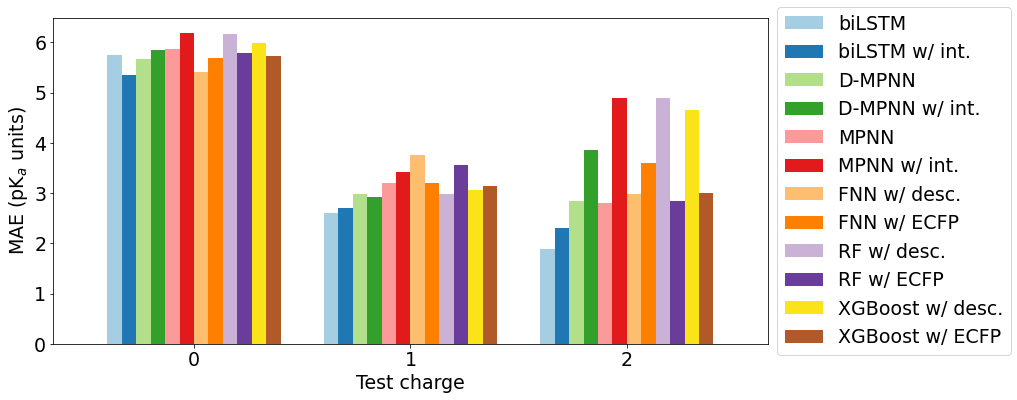

In [189]:
#LOCO
df = pd.read_csv('finalised_results/LOCO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','with attention':'w/ int.', 'with descriptors':'w/ desc.', 'with ECFP':'w/ ECFP'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOCO charge", columns="Model")
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

ax = df_pivot.plot.bar(color=colours, width=0.8)
fig = ax.get_figure()
fig.set_size_inches(16, 6)
ax.set_xlabel("Test charge")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),)
plt.savefig('LOCO.pdf', bbox_inches='tight')
plt.show()

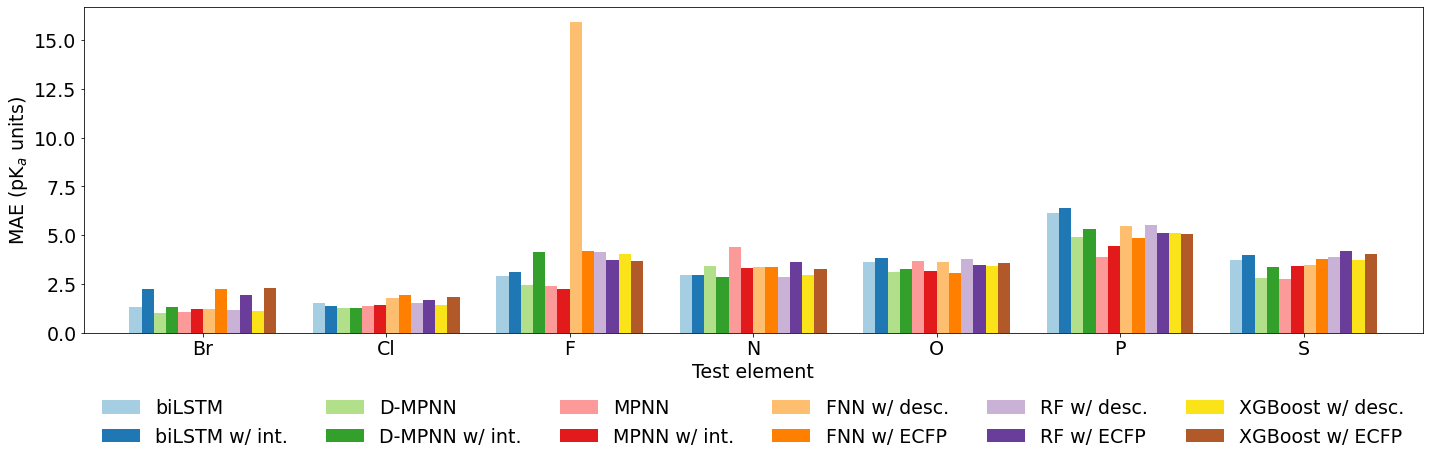

In [190]:
#LOEO
df = pd.read_csv('finalised_results/LOEO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','with attention':'w/ int.', 'with descriptors':'w/ desc.', 'with ECFP':'w/ ECFP'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOEO element", columns="Model")
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

ax = df_pivot.plot.bar(color=colours,width=0.8)
fig = ax.get_figure()
fig.set_size_inches(24, 6)
ax.set_xlabel("Test element")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=6, frameon=False)
plt.savefig('LOEO.pdf', bbox_inches='tight')
plt.show()

In [ ]:
sorted(list(df_pivot.columns.values), key=str.lower)

In [ ]:
model_names = ['biLSTM','biLSTM with attention','D-MPNN','D-MPNN with attention','MPNN','MPNN with attention',
               'NN with descriptors','NN with ECFP','RF with descriptors','RF with ECFP','XGBoost with descriptors','XGBoost with ECFP']
ids = [1,2,3,4,5,6,7,8,9,10,11]
cols = [model_names[i] for i in ids]
colour_sub =[colours[i] for i in ids]

fig, ax = plt.subplots(2, 2)

#LOEO 
df = pd.read_csv('finalised_results/LOEO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOEO element", columns="Model")
df_pivot = df_pivot[sorted(cols, key=str.lower)]

df_pivot.plot.bar(color=colour_sub, ax=ax[0,0], legend=False)
ax[0,0].set_xlabel("Test element")
ax[0,0].set_ylabel("MAE")

#LOCO
df = pd.read_csv('finalised_results/LOCO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOCO charge", columns="Model")
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax[0,1] = df_pivot.plot.bar(color=colour_sub, ax=ax[0,1], legend=False)
ax[0,1].set_xlabel("Test charge")
ax[0,1].set_ylabel("MAE")

#LOMO_high
df = pd.read_csv('finalised_results/LOMO_high_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOMO mass cutoff", columns="Model")
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax[1,0] = df_pivot.plot(color=colour_sub, ax=ax[1,0], legend=False, style='-o')
ax[1,0].set_xlabel("Minimum testing mass")
ax[1,0].set_ylabel("MAE")

#LOMO_low
df = pd.read_csv('finalised_results/LOMO_low_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'NN', 'RGBoost':'XGBoost','RNN':'biLSTM'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOMO mass cutoff", columns="Model")
df_pivot = df_pivot[sorted(cols, key=str.lower)]

ax[1,1] = df_pivot.plot(color=colour_sub, ax=ax[1,1], legend=False, style='-o')
ax[1,1].set_xlabel("Maximum testing mass")
ax[1,1].set_ylabel("MAE")

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, bbox_to_anchor=(0.85,0.07), fontsize=16)
fig.savefig('LOXO.png')
fig.set_size_inches(20,12)

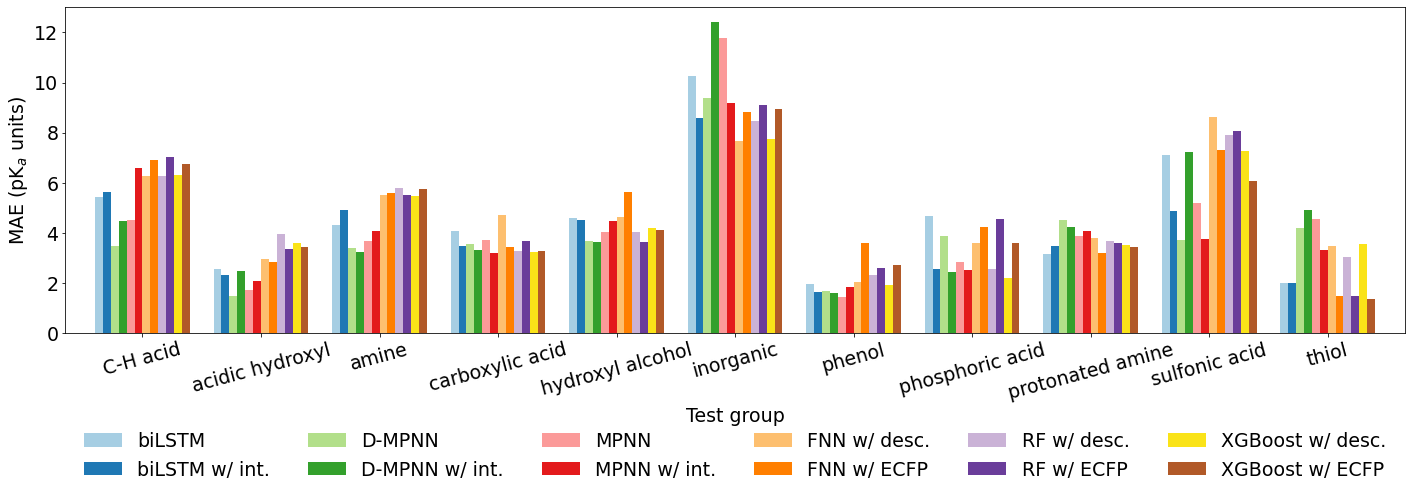

In [191]:
#LOFO
df = pd.read_csv('finalised_results/LOFO_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','with attention':'w/ int.', 'with descriptors':'w/ desc.', 'with ECFP':'w/ ECFP'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOFO group", columns="Model")
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

ax = df_pivot.plot.bar(color=colours, width=0.8)
fig = ax.get_figure()
fig.set_size_inches(24, 6)
ax.set_xlabel("Test group")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=15) 

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=False, shadow=False, ncol=6, frameon=False)
plt.savefig('LOFO.pdf', bbox_inches='tight')
plt.show()

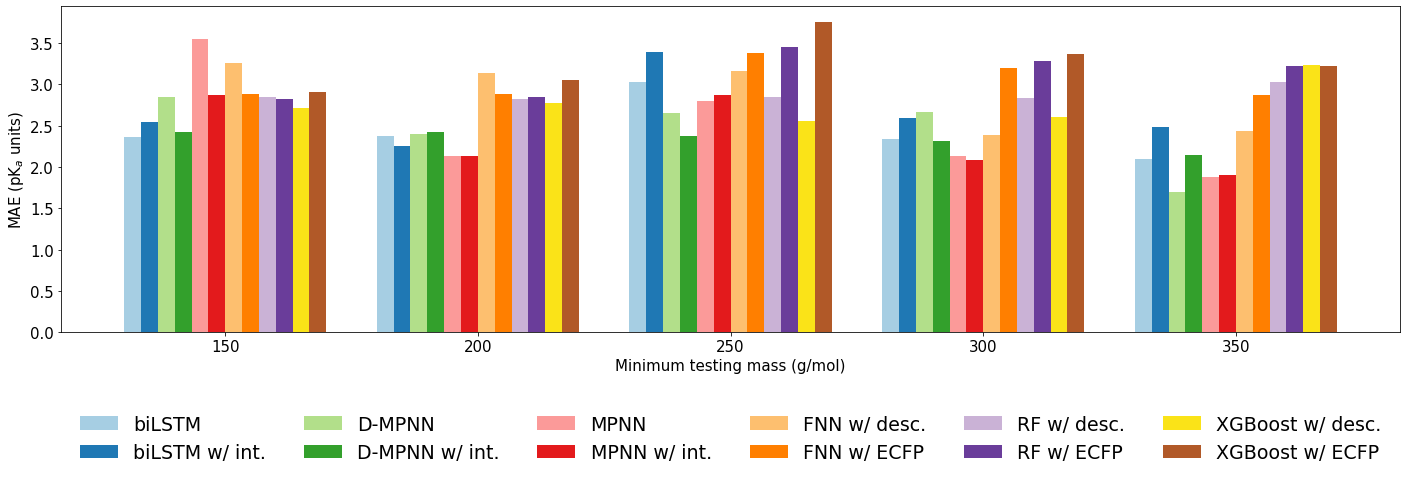

In [209]:
#LOMO_high
df = pd.read_csv('finalised_results/LOMO_high_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','with attention':'w/ int.', 'with descriptors':'w/ desc.', 'with ECFP':'w/ ECFP'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOMO mass cutoff", columns="Model")
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

ax = df_pivot.plot.bar(color=colours, width=0.8)
fig = ax.get_figure()
fig.set_size_inches(24, 6)
ax.set_xlabel("Minimum testing mass (g/mol)")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 

plt.rc("font",size=19)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=6, frameon=False)
plt.savefig('LOMO_high.pdf', bbox_inches='tight')
plt.show()

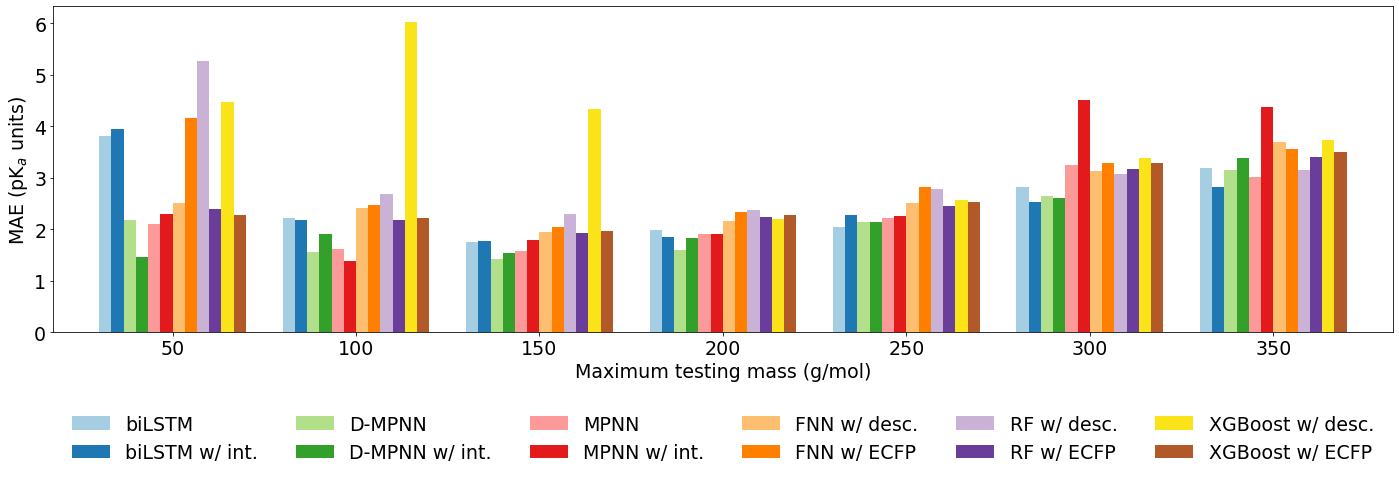

In [210]:
#LOMO_low
df = pd.read_csv('finalised_results/LOMO_low_test.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','with attention':'w/ int.', 'with descriptors':'w/ desc.', 'with ECFP':'w/ ECFP'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="LOMO mass cutoff", columns="Model")
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

ax = df_pivot.plot.bar(color=colours,width=0.8)
fig = ax.get_figure()
fig.set_size_inches(24, 6)
ax.set_xlabel("Maximum testing mass (g/mol)")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=6, frameon=False)
plt.savefig('LOMO_low.pdf', bbox_inches='tight')
plt.show()

['D-MPNN', 'D-MPNN w/ int.', 'Engineered representations', 'FNN w/ ECFP', 'FNN w/ desc.', 'Learned representations', 'MPNN', 'MPNN w/ int.', 'Message passing', 'RF w/ ECFP', 'RF w/ desc.', 'Tree-based learning', 'XGBoost w/ ECFP', 'XGBoost w/ desc.', 'biLSTM', 'biLSTM w/ int.']


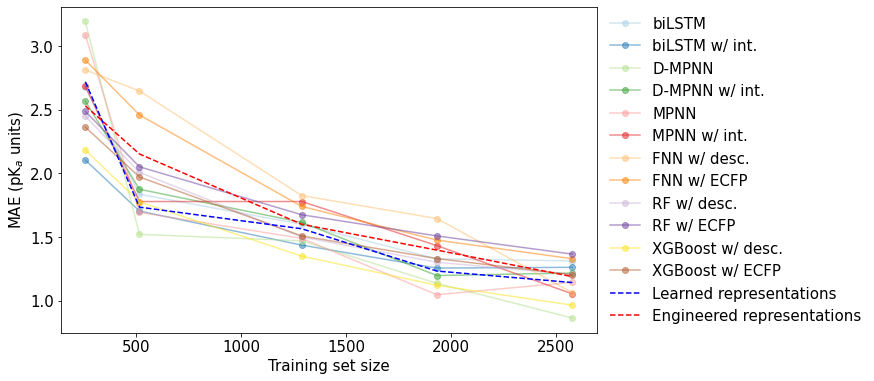

In [199]:
#train_prop_test
df = pd.read_csv('finalised_results/train_prop_test_new.csv')
df = df.replace({'Random forest': 'RF', 'MLP': 'FNN', 'RGBoost':'XGBoost','RNN':'biLSTM','attention':'int.','descriptors':'desc.',
                 'Deep learning':'Learned representations', 'Machine learning':'Engineered representations', 'with':'w/'}, regex=True)
df_pivot = pd.pivot_table(df, values="MAE", index="Train size", columns="Model")
cols = list(df_pivot.columns.values)
print(cols)
sep_df = df_pivot[[cols[5],cols[2]]]
cols = ['biLSTM', 'biLSTM w/ int.', 'D-MPNN', 'D-MPNN w/ int.', 'MPNN', 'MPNN w/ int.', 'FNN w/ desc.', 'FNN w/ ECFP', 
        'RF w/ desc.', 'RF w/ ECFP', 'XGBoost w/ desc.', 'XGBoost w/ ECFP']
df_pivot = df_pivot[cols]

fig, ax = plt.subplots()
df_pivot.plot(ax=ax, color=colours, style='-o',alpha=0.5)
sep_df.plot(ax=ax, color=['b','r'], style='--')
fig.set_size_inches(12, 6)
ax.set_xlabel("Training set size")
ax.set_ylabel("MAE (pK$_a$ units)")
plt.xticks(rotation=0) 

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.rc("font", size=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, prop={'size':15})

plt.savefig('prop.pdf', bbox_inches='tight')
plt.show()